In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import re
from nltk.tokenize import word_tokenize
import json


In [59]:
def clean_tweets(tweet):
    """Removes links and non-ASCII characters"""
    
    tweet = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    
    return tweet

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

def return_low(x):
    high = x["1"] - 1
    if(x["0"] > x["1"]): return (1-x["0"])
    else : return x["1"]

In [60]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
train.at[train['id'].isin(ids_with_target_error),'target'] = 0
train[train['id'].isin(ids_with_target_error)]

train = train.drop(train[train["text"].duplicated()].index)

# Put it in a JSON file
with open('./abbreviation.json') as json_file:
    abbreviations = json.load(json_file)

train["text"] = train["text"].apply(lambda x: clean_tweets(x))
test["text"] = test["text"].apply(lambda x: clean_tweets(x))

train["text"] = train["text"].apply(lambda x: remove_emoji(x))
test["text"] = test["text"].apply(lambda x: remove_emoji(x))

train["text"] = train["text"].apply(lambda x: remove_punctuations(x))
test["text"] = test["text"].apply(lambda x: remove_punctuations(x))

train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))


In [61]:
bert_full = pd.read_csv('./newTrainPredict.csv')["0"]
bert_full_around = bert_full.apply(lambda x: np.around(x))

bert_test = pd.read_csv('./newTestPredict.csv')["0"]
bert_test_around = bert_test.apply(lambda x: np.around(x))

elmo_full = pd.read_csv('./ELMo_Full_proba.csv')[["0", "1"]]
elmo_full = elmo_full.apply(return_low, axis = 1)
elmo_full_around = elmo_full.apply(lambda x: np.int(np.around(x)))

elmo_full = pd.read_csv('./ELMo_Full_proba.csv')[["0", "1"]]
elmo_full = elmo_full.apply(return_low, axis = 1)
elmo_full_around = elmo_full.apply(lambda x: np.int(np.around(x)))

elmo_test = pd.read_csv('./ELMo_test_proba.csv')[["0", "1"]]
elmo_test = elmo_test.apply(return_low, axis = 1)
elmo_test_around = elmo_test.apply(lambda x: np.int(np.around(x)))

y = train["text"]

In [62]:
bert_test

0       0.999944
1       0.999830
2       0.995121
3       0.999723
4       0.999703
5       0.993288
6       0.014801
7       0.037261
8       0.009614
9       0.015963
10      0.011372
11      0.006577
12      0.012396
13      0.041428
14      0.037336
15      0.991783
16      0.145031
17      0.880181
18      0.001973
19      0.013993
20      0.998060
21      0.357235
22      0.038438
23      0.991281
24      0.015521
25      0.055751
26      0.033323
27      0.136221
28      0.208042
29      0.938276
          ...   
3233    0.995877
3234    0.993660
3235    0.978977
3236    0.995877
3237    0.989381
3238    0.970494
3239    0.995877
3240    0.997326
3241    0.008616
3242    0.022669
3243    0.067722
3244    0.057267
3245    0.013357
3246    0.055709
3247    0.033897
3248    0.009189
3249    0.055719
3250    0.091344
3251    0.009064
3252    0.999455
3253    0.999922
3254    0.996115
3255    0.998913
3256    0.993609
3257    0.999972
3258    0.653631
3259    0.999819
3260    0.9994

# Comparison

In [63]:
train.index.shape

(7503,)

In [64]:
Predict = bert_full_around
Predict.index = train.index
bert_evaluationOnes = (Predict.loc[Predict == 1] == train.loc[Predict == 1]["target"])
bert_evaluationZeros = (Predict.loc[Predict == 0] == train.loc[Predict == 0]["target"])

tot_false = (bert_evaluationOnes[bert_evaluationOnes == False]).shape[0] + (bert_evaluationZeros[bert_evaluationZeros == False]).shape[0]

print("accuracy is ", 1-tot_false/train.index.shape[0])

FP_bert = train.loc[bert_evaluationOnes[bert_evaluationOnes == False].index]
FN_bert = train.loc[bert_evaluationZeros[bert_evaluationZeros == False].index]
print(np.shape(FP_bert), np.shape(FN_bert))

accuracy is  0.9566839930694389
(124, 5) (201, 5)


In [65]:
Predict = elmo_full_around
Predict.index = train.index
elmo_evaluationOnes = (Predict.loc[Predict == 1] == train.loc[Predict == 1]["target"])
elmo_evaluationZeros = (Predict.loc[Predict == 0] == train.loc[Predict == 0]["target"])

tot_false = (elmo_evaluationOnes[elmo_evaluationOnes == False]).shape[0] + (elmo_evaluationZeros[elmo_evaluationZeros == False]).shape[0]
print("accuracy is ", 1-tot_false/train.index.shape[0])

FP_elmo = train.loc[elmo_evaluationOnes[elmo_evaluationOnes == False].index]
FN_elmo = train.loc[elmo_evaluationZeros[elmo_evaluationZeros == False].index]
print(np.shape(FP_elmo), np.shape(FN_elmo))

accuracy is  0.8513927762228441
(418, 5) (697, 5)


In [66]:
combined_pd = pd.DataFrame({'bert': bert_full, 'elmo':elmo_full})
combined_pd = combined_pd.apply(lambda x: np.average(x), axis = 1)
combined_around_pd = combined_pd.apply(lambda x: np.int(np.around(x)))

Predict = combined_around_pd
Predict.index = train.index
combined_evaluationOnes = (Predict.loc[Predict == 1] == train.loc[Predict == 1]["target"])
combined_evaluationZeros = (Predict.loc[Predict == 0] == train.loc[Predict == 0]["target"])

tot_false = (combined_evaluationOnes[combined_evaluationOnes == False]).shape[0] + (combined_evaluationZeros[combined_evaluationZeros == False]).shape[0]

FP_comb = train.loc[combined_evaluationOnes[combined_evaluationOnes == False].index]
FN_comb = train.loc[combined_evaluationZeros[combined_evaluationZeros == False].index]
print("accuracy is ", 1-tot_false/train.index.shape[0])
print(np.shape(FP_comb), np.shape(FN_comb))



accuracy is  0.9456217512994802
(141, 5) (267, 5)


In [67]:
combined_test_pd = pd.DataFrame({'bert': bert_test, 'elmo':elmo_test})
combined_test_pd = combined_test_pd.apply(lambda x: np.average(x), axis = 1)
combined_test_around_pd = combined_test_pd.apply(lambda x: np.int(np.around(x)))

pd.DataFrame(combined_test_around_pd).to_csv('submission.csv', index = False, header=True)


In [68]:
pd.DataFrame(combined_test_around_pd)

,0
0,1
1,1
2,1
3,1
4,1
5,1
6,0
7,0
8,0
9,0


In [69]:
sample = pd.read_csv('./sample_submission.csv')
print(sample.head(20))
sample["target"] = pd.DataFrame(combined_around_pd)
sample.to_csv("submission.csv", index=False, header=True)

    id  target
0    0       0
1    2       0
2    3       0
3    9       0
4   11       0
5   12       0
6   21       0
7   22       0
8   27       0
9   29       0
10  30       0
11  35       0
12  42       0
13  43       0
14  45       0
15  46       0
16  47       0
17  51       0
18  58       0
19  60       0


In [70]:
print(sample.head(20))


    id  target
0    0     1.0
1    2     1.0
2    3     1.0
3    9     1.0
4   11     1.0
5   12     1.0
6   21     1.0
7   22     1.0
8   27     1.0
9   29     1.0
10  30     1.0
11  35     1.0
12  42     1.0
13  43     1.0
14  45     1.0
15  46     0.0
16  47     0.0
17  51     0.0
18  58     0.0
19  60     0.0


# Analysis

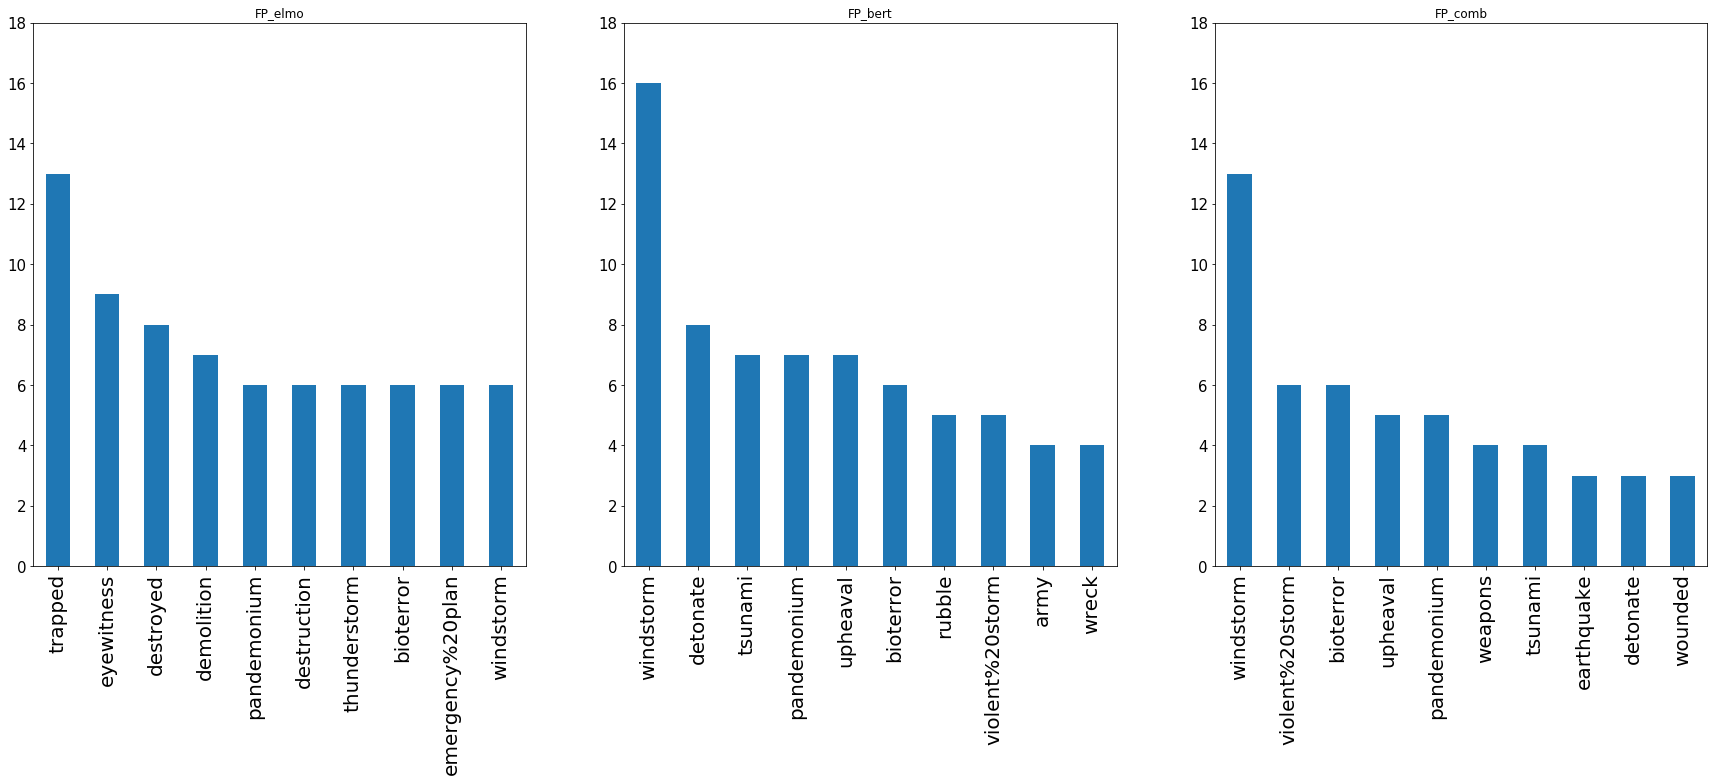

In [71]:
fig = plt.figure(figsize = (30,10))

ax = fig.add_subplot(131)
ax.axis([0, 10, 0, 18])
plt.xticks(size = 20)
plt.yticks(size = 15)
plt.title('FP_elmo')
FP_elmo["keyword"].value_counts().head(10).plot.bar(ax = ax)

ax = fig.add_subplot(132)
ax.axis([0, 10, 0, 18])
plt.xticks(size = 20)
plt.yticks(size = 15)
plt.title('FP_bert')
FP_bert["keyword"].value_counts().head(10).plot.bar(ax = ax)

ax = fig.add_subplot(133)
ax.axis([0, 10, 0, 18])
plt.xticks(size = 20)
plt.yticks(size = 15)
plt.title('FP_comb')
FP_comb["keyword"].value_counts().head(10).plot.bar(ax = ax)


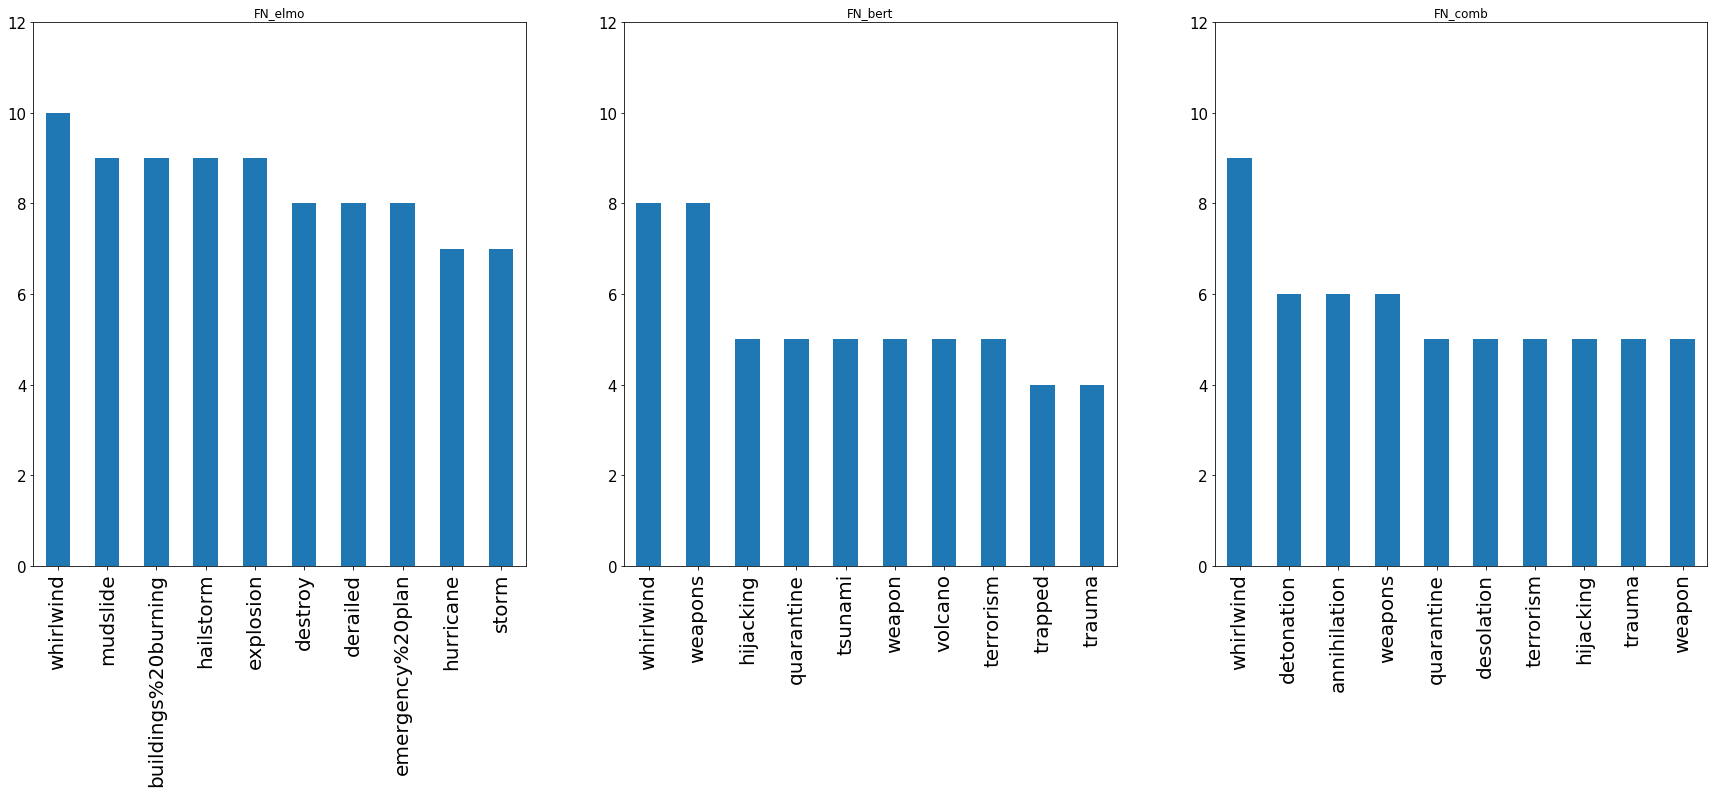

In [72]:
fig = plt.figure(figsize = (30,10))

ax = fig.add_subplot(131)
ax.axis([0, 10, 0, 12])
plt.title('FN_elmo')
plt.xticks(size = 20)
plt.yticks(size = 15)
FN_elmo["keyword"].value_counts().head(10).plot.bar(ax = ax)

ax = fig.add_subplot(132)
ax.axis([0, 10, 0, 12])
plt.xticks(size = 20)
plt.yticks(size = 15)
plt.title('FN_bert')
FN_bert["keyword"].value_counts().head(10).plot.bar(ax = ax)

ax = fig.add_subplot(133)
ax.axis([0, 10, 0, 12])
plt.xticks(size = 20)
plt.yticks(size = 15)
plt.title('FN_comb')
FN_comb["keyword"].value_counts().head(10).plot.bar(ax = ax)

# Confidence

In [73]:
def confidenceCalc(x):
    if x<0.5 : 
        return (0.5-x)*2
    else : 
        return (x-0.5)*2

In [74]:
Predict = elmo_full_around
Predict.index = train.index
elmo_full.index = train.index
TrueValues = elmo_full[train["target"] == Predict]
FalseValues = elmo_full[train["target"] != Predict]
meanTrueConf = TrueValues.apply(confidenceCalc).mean()
meanFalseConf = FalseValues.apply(confidenceCalc).mean()

print("True confidence :", meanTrueConf, "False confidence :", meanFalseConf)
print("Value diff :", meanTrueConf - meanFalseConf)

True confidence : 0.7855326118506482 False confidence : 0.5075404604472361
Value diff : 0.27799215140341205


In [75]:
Predict = bert_full_around
Predict.index = train.index
bert_full.index = train.index
TrueValues = bert_full[train["target"] == Predict]
FalseValues = bert_full[train["target"] != Predict]
meanTrueConf = TrueValues.apply(confidenceCalc).mean()
meanFalseConf = FalseValues.apply(confidenceCalc).mean()

print("True confidence :", meanTrueConf, "False confidence :", meanFalseConf)
print("Value diff :", meanTrueConf - meanFalseConf)

True confidence : 0.906751022706444 False confidence : 0.5669941794264618
Value diff : 0.33975684327998223


In [76]:
Predict = combined_around_pd
Predict.index = train.index
combined_pd.index = train.index
TrueValues = combined_pd[train["target"] == Predict]
FalseValues = combined_pd[train["target"] != Predict]
meanTrueConf = TrueValues.apply(confidenceCalc).mean()
meanFalseConf = FalseValues.apply(confidenceCalc).mean()

print("True confidence :", meanTrueConf, "False confidence :", meanFalseConf)
print("Value diff :", meanTrueConf - meanFalseConf)

True confidence : 0.7799500064231981 False confidence : 0.3566545923635499
Value diff : 0.4232954140596482


In [56]:
train["target"] == Predict

ValueError: Can only compare identically-labeled Series objects